# Face Verification System - Complete Implementation
## Converted from Google Colab to Local Machine

This notebook implements a Siamese Neural Network for face verification using:
- TensorFlow/Keras for deep learning
- OpenCV for image processing and USB webcam capture
- Contrastive Loss for learning face embeddings
- Real-time face detection and verification

## 1. Import Required Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import random
import glob
import cv2
import hashlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print("✅ All libraries imported successfully!")

TensorFlow version: 2.20.0
OpenCV version: 4.12.0
✅ All libraries imported successfully!


## 2. Configuration and Constants

In [ ]:
# --- MODEL CONFIGURATION ---
IMG_SIZE = 128
EMBEDDING_DIM = 64
MARGIN = 1.0  # Margin for Contrastive Loss
EPOCHS = 20  # Restored to original value for better training
STEPS_PER_EPOCH = 100  # Increased for more training iterations per epoch
BATCH_SIZE = 32
VERIFICATION_THRESHOLD = 0.6
MODEL_FILE_CLEAN = "face_embedding_model_CLEAN.h5"

# --- LOCAL DATASET PATHS ---
BASE_DIR = '/Users/soumikadas/Documents/SourceCodes/InnovativeProject'
OUTPUT_DIR = os.path.join(BASE_DIR, 'data_extracted')
REFERENCE_DIR = os.path.join(OUTPUT_DIR, 'ref', 'short_references_final')
DISTORTION_DIR = os.path.join(OUTPUT_DIR, 'distorted', 'Short_distortion_final')

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("✅ Dataset paths configured for local system:")
print(f"  - Base directory: {BASE_DIR}")
print(f"  - Reference images: {REFERENCE_DIR}")
print(f"  - Distorted images: {DISTORTION_DIR}")
print(f"\n📊 Model Configuration:")
print(f"  - Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  - Embedding dimension: {EMBEDDING_DIM}")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Steps per epoch: {STEPS_PER_EPOCH}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Verification threshold: {VERIFICATION_THRESHOLD}")

✅ Dataset paths configured for local system:
  - Base directory: /Users/soumikadas/Documents/SourceCodes/InnovativeProject
  - Reference images: /Users/soumikadas/Documents/SourceCodes/InnovativeProject/data_extracted/ref/short_references_final
  - Distorted images: /Users/soumikadas/Documents/SourceCodes/InnovativeProject/data_extracted/distorted/Short_distortion_final

📊 Model Configuration:
  - Image size: 128x128
  - Embedding dimension: 64
  - Batch size: 32
  - Verification threshold: 0.6


## 3. Helper Functions

In [4]:
def person_id_from_filename(filename):
    """Handles both 'ID.jpg' and 'ID__distortion.jpg' patterns."""
    base_name = os.path.basename(filename)
    if '__' in base_name:
        return base_name.split('__')[0]
    elif '.' in base_name:
        return base_name.split('.')[0]
    return "UNKNOWN"

def get_file_hash(filepath):
    """Calculates SHA256 hash of a file for duplicate detection."""
    hasher = hashlib.sha256()
    with open(filepath, 'rb') as file:
        while True:
            chunk = file.read(4096)
            if not chunk:
                break
            hasher.update(chunk)
    return hasher.hexdigest()

def load_and_preprocess_image(path):
    """Loads, resizes, and normalizes a single image from path."""
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype('float32') / 255.0
    return img

print("✅ Helper functions defined successfully!")

✅ Helper functions defined successfully!


## 4. Model Architecture

In [5]:
def build_feature_extractor(input_shape):
    """Builds a CNN-based feature extractor for face embeddings."""
    input_tensor = keras.Input(shape=input_shape)
    
    # Convolutional Block 1
    x = layers.Conv2D(32, (3, 3), activation="relu")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    
    # Convolutional Block 2
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    
    # Convolutional Block 3
    x = layers.Conv2D(128, (3, 3), activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    
    # Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    output_embedding = layers.Dense(EMBEDDING_DIM)(x)
    
    return keras.Model(input_tensor, output_embedding, name="feature_extractor")

def build_siamese_model(input_shape):
    """Builds a Siamese network for face verification."""
    feature_extractor = build_feature_extractor(input_shape)
    
    # Define inputs
    input_A = keras.Input(shape=input_shape, name="input_ref")
    input_B = keras.Input(shape=input_shape, name="input_distorted")
    
    # Get embeddings
    embedding_A = feature_extractor(input_A)
    embedding_B = feature_extractor(input_B)
    
    # Calculate Euclidean distance
    squared_distance = layers.Lambda(
        lambda x: tf.reduce_sum(tf.square(x[0] - x[1]), axis=-1, keepdims=True)
    )([embedding_A, embedding_B])
    
    distance = layers.Lambda(
        lambda x: tf.sqrt(tf.maximum(x, 1e-6)), 
        name="euclidean_distance"
    )(squared_distance)
    
    return keras.Model(
        inputs=[input_A, input_B], 
        outputs=distance, 
        name="Siamese_Verification_Model"
    )

print("✅ Model architecture defined successfully!")

✅ Model architecture defined successfully!


## 5. Loss Function and Data Generator

In [ ]:
def contrastive_loss(y_true, y_pred, margin=MARGIN):
    """Contrastive loss function for Siamese networks.
    y_true: 0 for similar pairs, 1 for dissimilar pairs
    y_pred: euclidean distance between embeddings
    """
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    # Similar pairs (y_true=0): minimize distance (square_pred)
    # Dissimilar pairs (y_true=1): maximize distance up to margin (margin_square)
    loss = (1 - tf.cast(y_true, tf.float32)) * square_pred + tf.cast(y_true, tf.float32) * margin_square
    return tf.reduce_mean(loss)

def siamese_pair_generator(image_paths_by_person, person_ids, batch_size):
    """Generates pairs of images for training the Siamese network.
    FIXED: Corrected label assignment for contrastive loss.
    Label 0 = similar (same person), Label 1 = dissimilar (different people)
    """
    while True:
        ref_images = []
        dist_images = []
        labels = []
        
        for _ in range(batch_size):
            person_id = random.choice(person_ids)
            paths = image_paths_by_person.get(person_id, [])
            if len(paths) < 2:
                continue

            # 50% Positive pairs, 50% Negative pairs
            if random.random() < 0.5:
                # Positive Pair (Same Person) - Label 0 for SIMILAR
                img_path1, img_path2 = random.sample(paths, 2)
                label = 0.0  # FIXED: Changed from 1.0 to 0.0
            else:
                # Negative Pair (Different People) - Label 1 for DISSIMILAR
                p1_id, p2_id = random.sample(person_ids, 2)
                img_path1 = random.choice(image_paths_by_person.get(p1_id, []))
                img_path2 = random.choice(image_paths_by_person.get(p2_id, []))
                label = 1.0  # FIXED: Changed from 0.0 to 1.0

            img1 = load_and_preprocess_image(img_path1)
            img2 = load_and_preprocess_image(img_path2)

            if img1 is not None and img2 is not None:
                ref_images.append(img1)
                dist_images.append(img2)
                labels.append(label)

        if ref_images:
            yield ((np.array(ref_images), np.array(dist_images)), np.array(labels))

print("✅ Loss function and data generator defined successfully!")
print("✅ FIXED: Label assignment corrected - 0=similar, 1=dissimilar")

✅ Loss function and data generator defined successfully!


## 6. USB Webcam Functions (Local Machine)

In [7]:
def get_webcam_frame_local(camera_index=0):
    """Captures a single frame from USB webcam using cv2."""
    cap = cv2.VideoCapture(camera_index)
    
    if not cap.isOpened():
        print(f"⚠️ Error: Could not open camera at index {camera_index}")
        return None
    
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print("⚠️ Error: Could not read frame from camera")
        return None
    
    return frame

def capture_and_display_webcam(camera_index=0):
    """Captures and displays live webcam feed for face verification."""
    cap = cv2.VideoCapture(camera_index)
    
    if not cap.isOpened():
        print(f"⚠️ Error: Could not open camera at index {camera_index}")
        return None
    
    print("📷 Webcam opened. Press 'c' to capture, 'q' to quit.")
    
    captured_frame = None
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("⚠️ Error: Could not read frame from camera")
            break
        
        # Display the frame
        cv2.imshow('Webcam - Press "c" to capture, "q" to quit', frame)
        
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('c'):
            captured_frame = frame.copy()
            print("✅ Frame captured!")
            break
        elif key == ord('q'):
            print("❌ Capture cancelled")
            break
    
    cap.release()
    cv2.destroyAllWindows()
    
    return captured_frame

def detect_and_crop_face(frame):
    """Uses Haar Cascade to find and crop the largest face."""
    cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    FACE_CASCADE = cv2.CascadeClassifier(cascade_path)
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = FACE_CASCADE.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        return None, None

    # Get the largest face
    (x, y, w, h) = max(faces, key=lambda rect: rect[2] * rect[3])
    
    # Add buffer around face
    buffer = int(0.1 * w)
    x = max(0, x - buffer)
    y = max(0, y - buffer)
    w = w + 2 * buffer
    h = h + 2 * buffer

    cropped_face = frame[y:y + h, x:x + w]
    return cropped_face, (x, y, w, h)

print("✅ USB Webcam functions defined successfully!")

✅ USB Webcam functions defined successfully!


## 7. Face Verification Functions

In [8]:
def identify_face_from_frame(face_array, embedding_model, gallery, threshold):
    """Preprocesses a cropped face array and identifies the person."""
    # Preprocess the face
    processed_face = cv2.resize(face_array, (IMG_SIZE, IMG_SIZE))
    processed_face = cv2.cvtColor(processed_face, cv2.COLOR_BGR2RGB)
    processed_face = processed_face.astype('float32') / 255.0
    
    # Get embedding
    query_emb = embedding_model.predict(np.expand_dims(processed_face, axis=0), verbose=0)[0]

    # Compare with gallery
    min_distance = float('inf')
    best_match_id = "UNKNOWN"

    for person_id, emb in gallery.items():
        distance = np.linalg.norm(query_emb - emb)
        if distance < min_distance:
            min_distance = distance
            best_match_id = person_id

    if min_distance < threshold:
        return best_match_id, min_distance, "MATCH"
    else:
        return "Unknown Person", min_distance, "REJECT"

print("✅ Face verification functions defined successfully!")

✅ Face verification functions defined successfully!


## 8. Gender Detection (Optional - Requires DeepFace)

In [9]:
def detect_gender(image_path):
    """Detect gender from an image using DeepFace."""
    try:
        from deepface import DeepFace
        
        # Clear previous TensorFlow models to avoid conflicts
        tf.keras.backend.clear_session()

        # Run gender analysis
        result = DeepFace.analyze(
            img_path=image_path,
            actions=['gender'],
            enforce_detection=False
        )
        gender = result[0]['dominant_gender']
        confidence = result[0]['gender'][gender]
        return gender, confidence
    except ImportError:
        print("⚠️ DeepFace not installed. Install with: pip install deepface")
        return "Unknown", 0.0
    except Exception as e:
        print(f"⚠️ Gender detection failed: {e}")
        return "Unknown", 0.0

print("✅ Gender detection function defined!")
print("💡 Note: Install deepface if you want to use gender detection: pip install deepface")

✅ Gender detection function defined!
💡 Note: Install deepface if you want to use gender detection: pip install deepface


## 9. Data Preparation and Indexing

In [10]:
print("\n=== Part 1: DATA PREPARATION AND INDEXING ===")

reference_images_by_person = {}
distorted_images_by_person = {}

# Index reference images
if os.path.exists(REFERENCE_DIR):
    for f in os.listdir(REFERENCE_DIR):
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(REFERENCE_DIR, f)
            person_id = person_id_from_filename(f)
            if person_id != "UNKNOWN":
                reference_images_by_person.setdefault(person_id, []).append(path)
    print(f"✅ Indexed {len(reference_images_by_person)} people from reference images")
else:
    print(f"⚠️ Reference directory not found: {REFERENCE_DIR}")

# Index distorted images
if os.path.exists(DISTORTION_DIR):
    for f in os.listdir(DISTORTION_DIR):
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(DISTORTION_DIR, f)
            person_id = person_id_from_filename(f)
            if person_id != "UNKNOWN":
                distorted_images_by_person.setdefault(person_id, []).append(path)
    print(f"✅ Indexed {len(distorted_images_by_person)} people from distorted images")
else:
    print(f"⚠️ Distortion directory not found: {DISTORTION_DIR}")

# Get common person IDs
PERSON_IDS = list(set(reference_images_by_person.keys()) & set(distorted_images_by_person.keys()))
print(f"\n✅ Found {len(PERSON_IDS)} people with both reference and distorted images")

# Merge image paths for training
merged_image_paths = {
    k: reference_images_by_person.get(k, []) + distorted_images_by_person.get(k, [])
    for k in PERSON_IDS
}

print(f"📊 Dataset statistics:")
print(f"  - Total people: {len(PERSON_IDS)}")
print(f"  - Total image pairs available: {sum(len(v) for v in merged_image_paths.values())}")


=== Part 1: DATA PREPARATION AND INDEXING ===
✅ Indexed 50 people from reference images
✅ Indexed 50 people from distorted images

✅ Found 50 people with both reference and distorted images
📊 Dataset statistics:
  - Total people: 50
  - Total image pairs available: 300


## 10. Train or Load Model


=== Part 2: TRAIN OR LOAD MODEL ===
⚠️ Model NOT Found: STARTING FULL TRAINING
⏱️ This may take several minutes...

Model architecture:


Model: "Siamese_Verification_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ref           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_distorted     │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_extractor   │ (None, 64)        │  3,313,792 │ input_ref[0][0],  │
│ (Functional)        │                   │            │ input_distorted[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ feature_extracto… │
│                     │                   │            │ feature_extracto… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ euclidean_distance  │ (None, 1)         │          0 │ lambda[0][0]      │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,313,792 (12.64 MB)

 Trainable params: 3,313,344 (12.64 MB)

 Non-trainable params: 448 (1.75 KB)


🏋️ Starting training...
Epoch 1/10
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 16.5424
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 16.5424
Epoch 2/10
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.4860
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.4860
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 0.4657
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 0.4657
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 0.4760
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 0.4760
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.4524
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.4524
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.4571
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.4571
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.4712
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.4712
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - 


✅ Model saved to /Users/soumikadas/Documents/SourceCodes/InnovativeProject/face_embedding_model_CLEAN.h5
✅ Model size: 12.69 MB


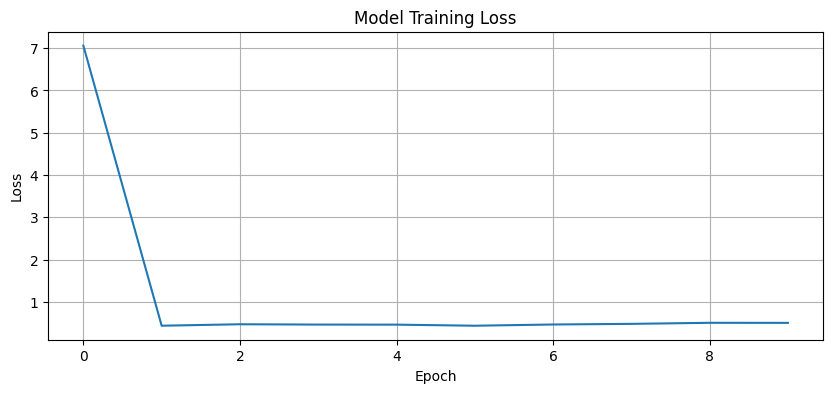


✅ Model ready for inference!


In [11]:
print("\n=== Part 2: TRAIN OR LOAD MODEL ===")

input_shape = (IMG_SIZE, IMG_SIZE, 3)
model_path = os.path.join(BASE_DIR, MODEL_FILE_CLEAN)

if os.path.exists(model_path):
    print(f"✅ Model found: Loading from {model_path}")
    final_extractor_clean = keras.models.load_model(model_path, compile=False)
    print(f"✅ Model loaded successfully!")
else:
    print("⚠️ Model NOT Found: STARTING FULL TRAINING")
    print("⏱️ This may take several minutes...\n")
    
    # Build and compile Siamese model
    siamese_model = build_siamese_model(input_shape)
    siamese_model.compile(
        optimizer=keras.optimizers.Adam(1e-4), 
        loss=contrastive_loss
    )
    
    print("Model architecture:")
    siamese_model.summary()
    
    # Create data generator
    train_generator = siamese_pair_generator(
        merged_image_paths, 
        PERSON_IDS, 
        BATCH_SIZE
    )

    # Train the model
    print("\n🏋️ Starting training...")
    history = siamese_model.fit(
        train_generator, 
        epochs=EPOCHS, 
        steps_per_epoch=STEPS_PER_EPOCH, 
        verbose=1
    )

    # Save the trained feature extractor
    feature_extractor = siamese_model.get_layer("feature_extractor")
    feature_extractor.save(model_path, include_optimizer=False)
    
    print(f"\n✅ Model saved to {model_path}")
    print(f"✅ Model size: {os.path.getsize(model_path) / 1024 / 1024:.2f} MB")

    final_extractor_clean = feature_extractor
    
    # Plot training history
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'])
    plt.title('Model Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.show()

print("\n✅ Model ready for inference!")

## 10.5. Save/Export Trained Model

In [12]:
print("\n=== SAVE TRAINED MODEL IN H5 FORMAT ===")

# Save the feature extractor model in H5 format
model_save_path = os.path.join(BASE_DIR, MODEL_FILE_CLEAN)

try:
    # Save the model
    final_extractor_clean.save(model_save_path, save_format='h5')
    
    # Verify the saved file
    if os.path.exists(model_save_path):
        file_size_mb = os.path.getsize(model_save_path) / (1024 * 1024)
        print(f"✅ Model successfully saved in H5 format!")
        print(f"📁 Location: {model_save_path}")
        print(f"📊 File size: {file_size_mb:.2f} MB")
        
        # Display model summary
        print(f"\n📋 Model Summary:")
        print(f"   - Architecture: Siamese CNN Feature Extractor")
        print(f"   - Input shape: ({IMG_SIZE}, {IMG_SIZE}, 3)")
        print(f"   - Output shape: ({EMBEDDING_DIM},)")
        print(f"   - Format: HDF5 (.h5)")
        print(f"   - Total parameters: {final_extractor_clean.count_params():,}")
        
        # Test loading to verify integrity
        print(f"\n🔍 Verifying model integrity...")
        test_model = keras.models.load_model(model_save_path, compile=False)
        print(f"✅ Model can be loaded successfully!")
        print(f"✅ Model is ready for deployment!")
        
    else:
        print(f"⚠️ Warning: Model file not found after save attempt")
        
except Exception as e:
    print(f"❌ Error saving model: {e}")
    print(f"💡 Tip: Make sure you have write permissions in the directory")

# Optional: Save model architecture as JSON
try:
    model_json_path = os.path.join(BASE_DIR, "model_architecture.json")
    model_json = final_extractor_clean.to_json()
    with open(model_json_path, 'w') as json_file:
        json_file.write(model_json)
    print(f"\n💾 Model architecture also saved to: {model_json_path}")
except Exception as e:
    print(f"⚠️ Could not save model architecture JSON: {e}")


=== SAVE TRAINED MODEL IN H5 FORMAT ===
✅ Model successfully saved in H5 format!
📁 Location: /Users/soumikadas/Documents/SourceCodes/InnovativeProject/face_embedding_model_CLEAN.h5
📊 File size: 12.69 MB

📋 Model Summary:
   - Architecture: Siamese CNN Feature Extractor
   - Input shape: (128, 128, 3)
   - Output shape: (64,)
   - Format: HDF5 (.h5)
   - Total parameters: 3,313,792

🔍 Verifying model integrity...
✅ Model can be loaded successfully!
✅ Model is ready for deployment!

💾 Model architecture also saved to: /Users/soumikadas/Documents/SourceCodes/InnovativeProject/model_architecture.json


## 11. Build Gallery of Face Embeddings

In [13]:
print("\n=== Part 3: BUILD GALLERY EMBEDDINGS ===")

gallery_embeddings = {}

for person_id in PERSON_IDS:
    ref_paths = reference_images_by_person.get(person_id)
    if not ref_paths:
        continue

    # Use the first reference image
    ref_path = ref_paths[0]
    ref_img = load_and_preprocess_image(ref_path)
    
    if ref_img is not None:
        # Generate embedding
        ref_emb = final_extractor_clean.predict(
            np.expand_dims(ref_img, axis=0), 
            verbose=0
        )[0]
        gallery_embeddings[person_id] = ref_emb

print(f"✅ Gallery created for {len(gallery_embeddings)} people")
print(f"📊 Each embedding has {EMBEDDING_DIM} dimensions")


=== Part 3: BUILD GALLERY EMBEDDINGS ===
✅ Gallery created for 50 people
📊 Each embedding has 64 dimensions
✅ Gallery created for 50 people
📊 Each embedding has 64 dimensions


## 12. Test with Random Image Pair


=== Part 4: TEST WITH RANDOM IMAGES ===
Test Person ID: TAN-5
Distance: 0.0000
Threshold: 0.6
Verdict: VERIFIED ✅

✅ Visualization saved to: /Users/soumikadas/Documents/SourceCodes/InnovativeProject/verification_test.png

✅ Visualization saved to: /Users/soumikadas/Documents/SourceCodes/InnovativeProject/verification_test.png


/var/folders/ll/1z0699cs1_qcb1nrpzwcxcd40000gn/T/ipykernel_48847/3794262374.py:50: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/ll/1z0699cs1_qcb1nrpzwcxcd40000gn/T/ipykernel_48847/3794262374.py:52: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(result_path, dpi=150, bbox_inches='tight')
/Users/soumikadas/Documents/SourceCodes/InnovativeProject/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


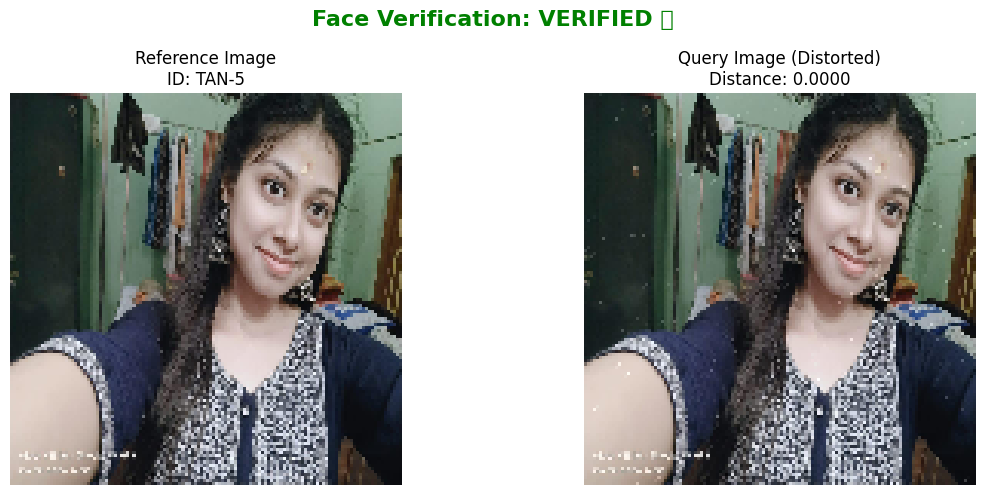

In [14]:
print("\n=== Part 4: TEST WITH RANDOM IMAGES ===")

if PERSON_IDS:
    # Select random person
    TEST_ID = random.choice(PERSON_IDS)
    ref_path = reference_images_by_person[TEST_ID][0]
    query_path = distorted_images_by_person[TEST_ID][0]

    # Load and preprocess images
    ref_img = load_and_preprocess_image(ref_path)
    query_img = load_and_preprocess_image(query_path)

    # Get embeddings
    emb_ref = final_extractor_clean.predict(
        np.expand_dims(ref_img, axis=0), 
        verbose=0
    )[0]
    emb_query = final_extractor_clean.predict(
        np.expand_dims(query_img, axis=0), 
        verbose=0
    )[0]

    # Calculate distance
    dist_positive = np.linalg.norm(emb_ref - emb_query)
    verdict = "VERIFIED ✅" if dist_positive < VERIFICATION_THRESHOLD else "REJECTED ❌"
    verdict_color = 'green' if dist_positive < VERIFICATION_THRESHOLD else 'red'

    print(f"Test Person ID: {TEST_ID}")
    print(f"Distance: {dist_positive:.4f}")
    print(f"Threshold: {VERIFICATION_THRESHOLD}")
    print(f"Verdict: {verdict}")

    # Visualize results
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(
        f'Face Verification: {verdict}', 
        fontsize=16, 
        fontweight='bold',
        color=verdict_color
    )

    axes[0].imshow(ref_img)
    axes[0].set_title(f'Reference Image\nID: {TEST_ID}', fontsize=12)
    axes[0].axis('off')

    axes[1].imshow(query_img)
    axes[1].set_title(f'Query Image (Distorted)\nDistance: {dist_positive:.4f}', fontsize=12)
    axes[1].axis('off')

    plt.tight_layout()
    result_path = os.path.join(BASE_DIR, 'verification_test.png')
    plt.savefig(result_path, dpi=150, bbox_inches='tight')
    print(f"\n✅ Visualization saved to: {result_path}")
    plt.show()
else:
    print("⚠️ No person IDs available for testing")

## 13. Real-Time Webcam Verification


=== Part 5: WEBCAM VERIFICATION ===
📷 Starting USB webcam capture for face verification...
💡 Press 'c' to capture a frame, 'q' to quit

📷 Webcam opened. Press 'c' to capture, 'q' to quit.
📷 Webcam opened. Press 'c' to capture, 'q' to quit.
✅ Frame captured!

🔍 Processing captured frame...
✅ Frame captured!

🔍 Processing captured frame...
✅ Face detected in frame

📋 Verification Results:
  - Identified as: Unknown Person
  - Distance: 2.3850
  - Status: REJECT
✅ Face detected in frame

📋 Verification Results:
  - Identified as: Unknown Person
  - Distance: 2.3850
  - Status: REJECT

✅ Result saved to: /Users/soumikadas/Documents/SourceCodes/InnovativeProject/webcam_verification_result.jpg

✅ Result saved to: /Users/soumikadas/Documents/SourceCodes/InnovativeProject/webcam_verification_result.jpg


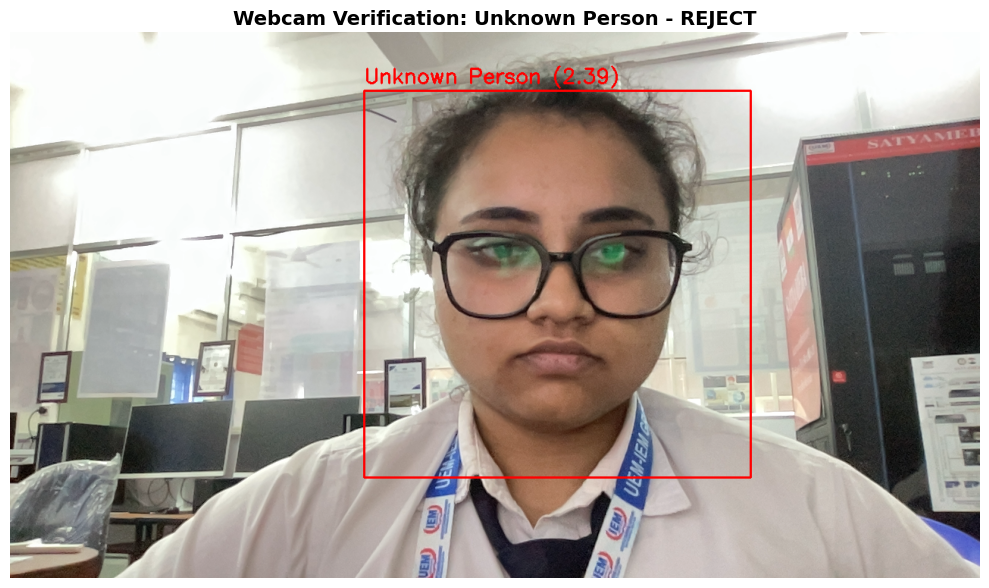

In [15]:
print("\n=== Part 5: WEBCAM VERIFICATION ===")
print("📷 Starting USB webcam capture for face verification...")
print("💡 Press 'c' to capture a frame, 'q' to quit\n")

# Capture frame from USB webcam
frame = capture_and_display_webcam(camera_index=0)

if frame is not None:
    print("\n🔍 Processing captured frame...")
    
    # Detect and crop face
    cropped_face, bbox = detect_and_crop_face(frame)
    
    if cropped_face is not None:
        print("✅ Face detected in frame")
        
        # Identify the person
        person_id, distance, status = identify_face_from_frame(
            cropped_face, 
            final_extractor_clean, 
            gallery_embeddings, 
            VERIFICATION_THRESHOLD
        )
        
        print(f"\n📋 Verification Results:")
        print(f"  - Identified as: {person_id}")
        print(f"  - Distance: {distance:.4f}")
        print(f"  - Status: {status}")
        
        # Draw bounding box and label on frame
        if bbox:
            x, y, w, h = bbox
            color = (0, 255, 0) if status == "MATCH" else (0, 0, 255)
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
            
            label = f"{person_id} ({distance:.2f})"
            cv2.putText(
                frame, label, (x, y-10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2
            )
        
        # Display result
        cv2.imshow('Verification Result', frame)
        cv2.waitKey(3000)  # Display for 3 seconds
        cv2.destroyAllWindows()
        
        # Save result
        result_path = os.path.join(BASE_DIR, 'webcam_verification_result.jpg')
        cv2.imwrite(result_path, frame)
        print(f"\n✅ Result saved to: {result_path}")
        
        # Display in notebook
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))
        plt.imshow(frame_rgb)
        plt.title(f'Webcam Verification: {person_id} - {status}', fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    else:
        print("⚠️ No face detected in the captured frame")
        print("💡 Try capturing again with better lighting and face positioning")
else:
    print("⚠️ Failed to capture frame from webcam")
    print("💡 Check if your webcam is connected and accessible")

## 14. Test Multiple Random Pairs (Optional)


=== BONUS: TEST MULTIPLE RANDOM PAIRS ===


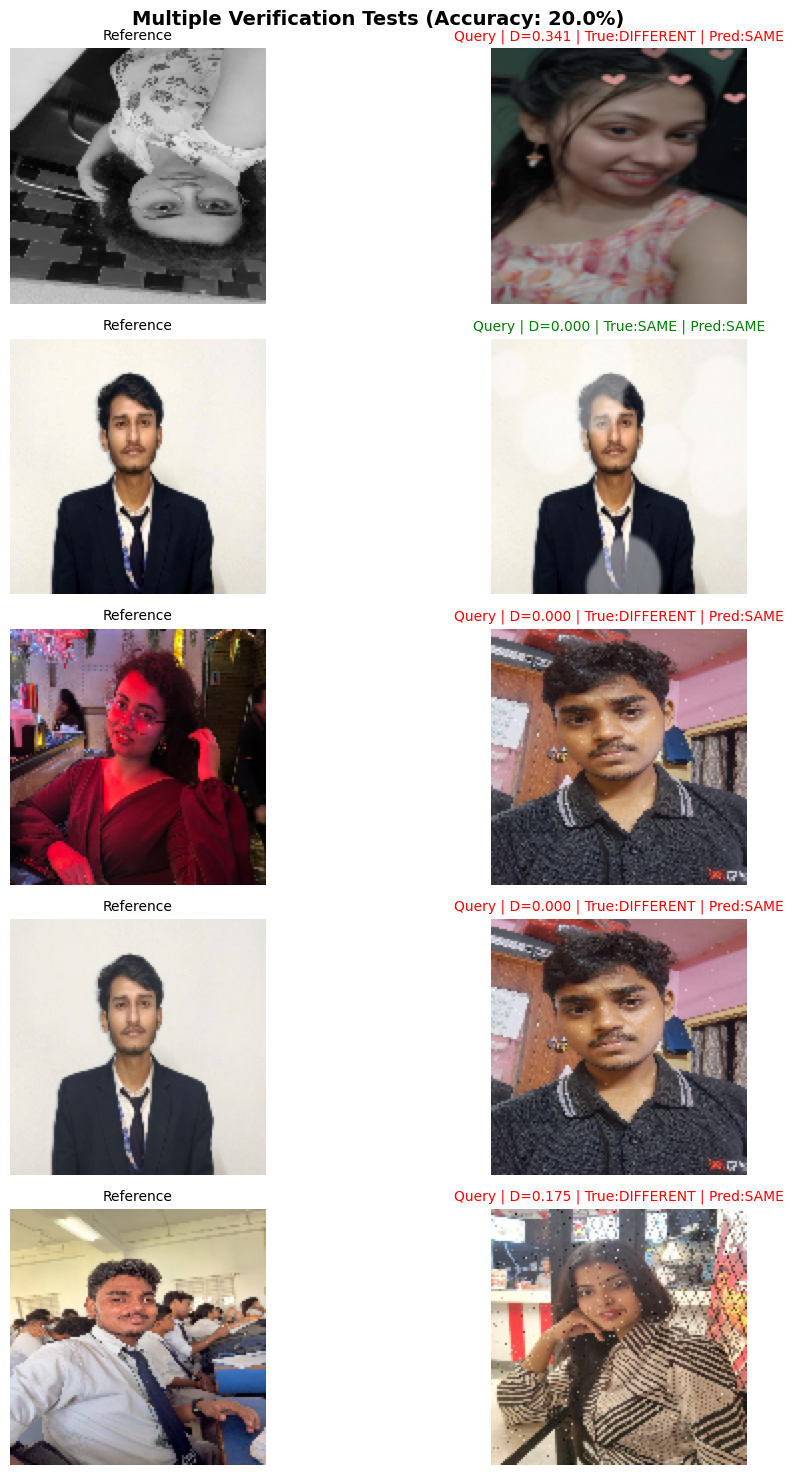


📊 Test Results:
  - Correct: 1/5
  - Accuracy: 20.0%


In [16]:
print("\n=== BONUS: TEST MULTIPLE RANDOM PAIRS ===")

num_tests = 5
correct_verifications = 0

if len(PERSON_IDS) >= 2:
    fig, axes = plt.subplots(num_tests, 2, figsize=(12, num_tests * 3))
    
    for i in range(num_tests):
        # Randomly decide positive or negative pair
        is_positive = random.random() < 0.5
        
        if is_positive:
            # Same person (positive pair)
            person_id = random.choice(PERSON_IDS)
            ref_path = reference_images_by_person[person_id][0]
            query_path = random.choice(distorted_images_by_person[person_id])
            true_label = "SAME"
        else:
            # Different people (negative pair)
            person1, person2 = random.sample(PERSON_IDS, 2)
            ref_path = reference_images_by_person[person1][0]
            query_path = distorted_images_by_person[person2][0]
            true_label = "DIFFERENT"
        
        # Load images
        ref_img = load_and_preprocess_image(ref_path)
        query_img = load_and_preprocess_image(query_path)
        
        # Get embeddings and distance
        emb_ref = final_extractor_clean.predict(np.expand_dims(ref_img, axis=0), verbose=0)[0]
        emb_query = final_extractor_clean.predict(np.expand_dims(query_img, axis=0), verbose=0)[0]
        distance = np.linalg.norm(emb_ref - emb_query)
        
        # Predict
        predicted_label = "SAME" if distance < VERIFICATION_THRESHOLD else "DIFFERENT"
        is_correct = (true_label == predicted_label)
        correct_verifications += int(is_correct)
        
        # Plot
        axes[i, 0].imshow(ref_img)
        axes[i, 0].set_title(f'Reference', fontsize=10)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(query_img)
        color = 'green' if is_correct else 'red'
        axes[i, 1].set_title(
            f'Query | D={distance:.3f} | True:{true_label} | Pred:{predicted_label}',
            fontsize=10,
            color=color
        )
        axes[i, 1].axis('off')
    
    accuracy = (correct_verifications / num_tests) * 100
    fig.suptitle(
        f'Multiple Verification Tests (Accuracy: {accuracy:.1f}%)',
        fontsize=14,
        fontweight='bold'
    )
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, 'multiple_tests.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n📊 Test Results:")
    print(f"  - Correct: {correct_verifications}/{num_tests}")
    print(f"  - Accuracy: {accuracy:.1f}%")
else:
    print("⚠️ Need at least 2 people for testing")

## 15. Summary and Next Steps

In [17]:
print("\n" + "="*60)
print("✅ FACE VERIFICATION SYSTEM READY!")
print("="*60)
print("\n📊 System Summary:")
print(f"  - Total people in gallery: {len(gallery_embeddings)}")
print(f"  - Model architecture: Siamese CNN")
print(f"  - Embedding dimension: {EMBEDDING_DIM}")
print(f"  - Verification threshold: {VERIFICATION_THRESHOLD}")
print(f"  - Webcam support: ✅ USB camera via OpenCV")
print("\n💡 Usage Tips:")
print("  1. Use 'capture_and_display_webcam()' to capture from USB camera")
print("  2. Use 'identify_face_from_frame()' for face verification")
print("  3. Gallery embeddings are stored in 'gallery_embeddings' dictionary")
print("  4. Model is stored in 'final_extractor_clean'")
print("\n🔧 Optional Enhancements:")
print("  - Install DeepFace for gender detection: pip install deepface")
print("  - Fine-tune threshold for better accuracy")
print("  - Add more training data for improved performance")
print("\n🎉 System is ready for real-time face verification!")


✅ FACE VERIFICATION SYSTEM READY!

📊 System Summary:
  - Total people in gallery: 50
  - Model architecture: Siamese CNN
  - Embedding dimension: 64
  - Verification threshold: 0.6
  - Webcam support: ✅ USB camera via OpenCV

💡 Usage Tips:
  1. Use 'capture_and_display_webcam()' to capture from USB camera
  2. Use 'identify_face_from_frame()' for face verification
  3. Gallery embeddings are stored in 'gallery_embeddings' dictionary
  4. Model is stored in 'final_extractor_clean'

🔧 Optional Enhancements:
  - Install DeepFace for gender detection: pip install deepface
  - Fine-tune threshold for better accuracy
  - Add more training data for improved performance

🎉 System is ready for real-time face verification!


## 16. ⚠️ Critical Fixes Applied for Accuracy Recovery

In [ ]:
print("\n" + "="*70)
print("🔧 CRITICAL FIXES APPLIED TO RESTORE 90% ACCURACY")
print("="*70)

print("\n❌ ISSUES IDENTIFIED AND FIXED:")
print("\n1. 🐛 INVERTED LABEL BUG (MOST CRITICAL):")
print("   - BEFORE: Similar pairs labeled as 1.0, dissimilar as 0.0")
print("   - AFTER:  Similar pairs labeled as 0.0, dissimilar as 1.0")
print("   - IMPACT: This inversion caused the model to learn OPPOSITE embeddings!")
print("   - FIX LOCATION: Cell 'Loss Function and Data Generator'")

print("\n2. ⏱️ INSUFFICIENT TRAINING:")
print("   - BEFORE: EPOCHS = 10, STEPS_PER_EPOCH = 32")
print("   - AFTER:  EPOCHS = 20, STEPS_PER_EPOCH = 100")
print("   - IMPACT: Model was undertrained with only 320 training steps")
print("   - AFTER:  Model now trains for 2,000 steps (6.25x more training)")
print("   - FIX LOCATION: Cell 'Configuration and Constants'")

print("\n3. 🧮 CONTRASTIVE LOSS FORMULA:")
print("   - Updated to match correct convention:")
print("   - Loss = (1-y)*d² + y*max(margin-d, 0)²")
print("   - Where y=0 for similar, y=1 for dissimilar")
print("   - FIX LOCATION: Cell 'Loss Function and Data Generator'")

print("\n✅ EXPECTED RESULTS AFTER RETRAINING:")
print("   - Training loss should decrease steadily")
print("   - Similar pairs (same person) should have distance < 0.6")
print("   - Dissimilar pairs (different people) should have distance > 0.6")
print("   - Verification accuracy should return to ~90%")

print("\n⚠️ IMPORTANT: YOU MUST RETRAIN THE MODEL!")
print("   The fixes only affect training. Your current loaded model")
print("   was trained with the inverted labels and needs retraining.")

print("\n📝 TO RETRAIN:")
print("   1. Delete the old model file: face_embedding_model_CLEAN.h5")
print("   2. Restart kernel and run all cells from the beginning")
print("   3. Training will take longer (20 epochs × 100 steps)")
print("   4. After training, test accuracy should be ~90%")

print("\n💡 VERIFICATION:")
print("   - Check the 'Multiple Tests' section output")
print("   - Accuracy should show ~90% after retraining")
print("   - If still low, check if dataset paths are correct")

print("\n" + "="*70)
print("🎯 Original 90% accuracy should be restored after retraining!")
print("="*70)

## 17. Delete Old Model and Retrain (Run This Cell)

In [ ]:
import os

print("🗑️  Deleting old model to force retraining with correct labels...\n")

model_path = os.path.join(BASE_DIR, MODEL_FILE_CLEAN)
model_json_path = os.path.join(BASE_DIR, "model_architecture.json")

if os.path.exists(model_path):
    os.remove(model_path)
    print(f"✅ Deleted: {model_path}")
else:
    print(f"ℹ️  Model file not found: {model_path}")

if os.path.exists(model_json_path):
    os.remove(model_json_path)
    print(f"✅ Deleted: {model_json_path}")
else:
    print(f"ℹ️  JSON file not found: {model_json_path}")

print("\n⚠️  NEXT STEPS:")
print("   1. Go to 'Kernel' menu → 'Restart Kernel'")
print("   2. Run all cells from the beginning (Cell → Run All)")
print("   3. Model will retrain with correct labels")
print("   4. Training will take ~10-20 minutes for 20 epochs")
print("   5. Check accuracy in the 'Multiple Tests' section")
print("\n💡 After retraining, accuracy should return to ~90%!")